# Poissson Hidden Markov Models

In [1]:
import sys
sys.path.insert(0, "../models/")

In [84]:
import numpy as np
from matplotlib import pyplot as plt

In [85]:
%matplotlib notebook

In [3]:
from HMM import HMM
from posteriors import gamma, dirichlet, simul_s, _poisson
from simulation import simul_poisson

# We will fit a two component poisson HMM

A 2 components poisson HMM is made of :
* A posterior `gamma` distribution over $\theta = \lambda \in IR^2$
* A posterior distribution over $S \in IR^n$, the states vector; where $n = #obs$
* A posterior `dirichlet` distribution over the transition matrix $P \in IR^{2x2}$

We start by definig the posterior of $ \lambda$

In [4]:
tDictDist = {"_lambda": gamma()}

#Let set the default parameter
# tDictDist["_lambda"]._set(a = np.array([1, 1/2]))
# tDictDist["_lambda"]._set(scale = np.array([1/2, 1]))
tDictDist["_lambda"]._set_default(a = np.array([1, 1/2]))
tDictDist["_lambda"]._set_default(scale = np.array([1/2, 1]))

Now, the **S** distribtuion ...

In [5]:
sDist = simul_s(func = _poisson) # S distribution

Now the $P$ distribution

In [6]:
pDist = dirichlet() # A dirichlet distribution is common for probability vectors
pDist._set(a = np.array([[0.5, 0.5], [0.5,0.5]]))

In [7]:
pDist.default

{'a': 1}

# The poisson mixture on an artificial data

## The simulated distribution

Let's simulate an artificial poisson mixture

In [8]:
P0 = np.array([[0.2, 0.8], [0.6, 0.4]]) # the 'true' transition matrix
theta0 = np.array([1., 10.]) # The true lambdas

(array([359., 113.,  40.,  92.,  50., 121., 123.,  70.,  24.,   8.]),
 array([ 0. ,  1.8,  3.6,  5.4,  7.2,  9. , 10.8, 12.6, 14.4, 16.2, 18. ]),
 <a list of 10 Patch objects>)

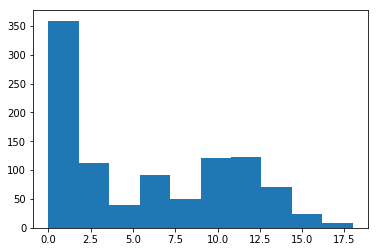

In [9]:
y, SS0 = simul_poisson(P0, theta0, size = 1000) # Simulate 1000 sample of poisson mixtures
plt.hist(y)

## Running the HMM

In [10]:
Y = y
Theta = {"_lambda" : np.array([5,5])} # Initial lambdas, any !
S = np.random.choice(2, len(Y)) # Initial S, random !
P = np.array([[0.5,0.5],[0.5,0.5]]) # Initial P, any !

In [11]:
phmm = HMM(tDictDist, sDist, pDist, Y=Y, S = S, Theta = Theta, P = P )

In [26]:
phmm.run(3000, historise = True) # Start the gibbs sampler n-times

## Checking for auto-correlation in the chain

In [93]:
from utils import plot_ACF

lambdas = np.array([x["_lambda"] for x in phmm.H["Theta"]])

<IPython.core.display.Javascript object>


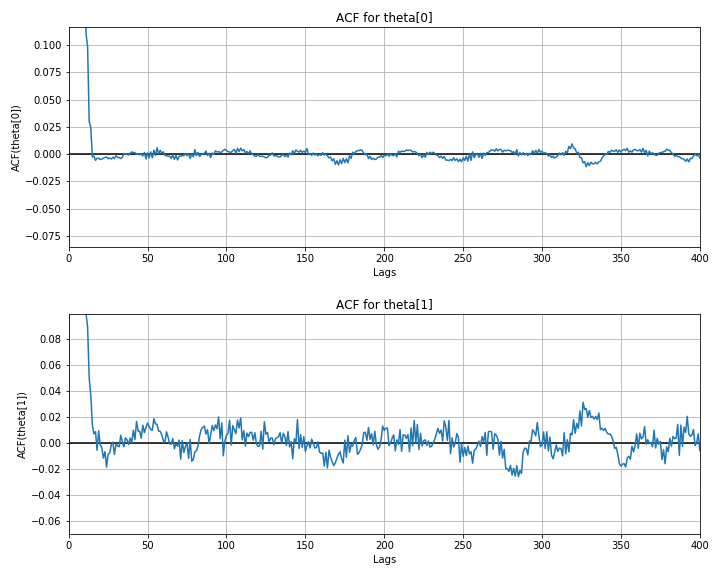

In [109]:
plot_ACF(lambdas, nlags = 400)

# Can we recover the true clusters ? Let's see !

<IPython.core.display.Javascript object>


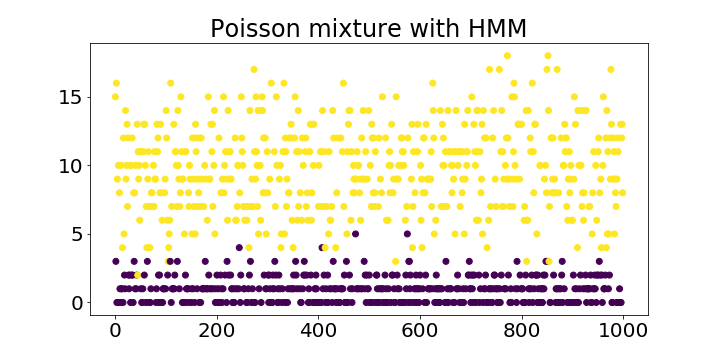

Text(0.5, 1.0, 'Poisson mixture with HMM')

In [130]:
plt.figure(figsize = (10, 5))
plt.scatter(np.arange(len(Y)), Y, c= phmm.S)
plt.title("Poisson mixture with HMM")

In [122]:
error_rate = (phmm.S == SS0).mean()*100 # Precision or Error rate
print("{} % of precision".format(error_rate))

98.0 % of precision


## Recover the parameters

In [115]:
lambdas[400:].mean(axis = 0).round(2) # Our estimates are quite good

array([0.97, 9.83])

In [119]:
np.array(phmm.H["P"])[400:].mean(axis = 0).round(2)

array([[0.46, 0.54],
       [0.49, 0.51]])

## The end of the chain

In [99]:
phmm.H["Theta"][-10::] # Last 10 lambda samples

[{'_lambda': array([0.95684471, 9.69401283])},
 {'_lambda': array([0.97029427, 9.99559345])},
 {'_lambda': array([0.93937898, 9.66016153])},
 {'_lambda': array([1.00898752, 9.91052669])},
 {'_lambda': array([0.98510932, 9.96309624])},
 {'_lambda': array([0.95791738, 9.74007343])},
 {'_lambda': array([0.89331433, 9.63312185])},
 {'_lambda': array([0.88021017, 9.91424075])},
 {'_lambda': array([0.9282625 , 9.70760275])},
 {'_lambda': array([0.88055205, 9.62934571])}]

In [101]:
phmm.H["P"][-10::] # Last ten sample of P

[array([[0.45589699, 0.54410301],
        [0.46876634, 0.53123366]]), array([[0.47171874, 0.52828126],
        [0.46399678, 0.53600322]]), array([[0.44751112, 0.55248888],
        [0.47359396, 0.52640604]]), array([[0.45316758, 0.54683242],
        [0.49814888, 0.50185112]]), array([[0.47088312, 0.52911688],
        [0.46297506, 0.53702494]]), array([[0.46898816, 0.53101184],
        [0.48045242, 0.51954758]]), array([[0.49505833, 0.50494167],
        [0.46082125, 0.53917875]]), array([[0.43782486, 0.56217514],
        [0.50473515, 0.49526485]]), array([[0.50021373, 0.49978627],
        [0.45301722, 0.54698278]]), array([[0.45393722, 0.54606278],
        [0.50184986, 0.49815014]])]